In [444]:
import pandas as pd
import numpy as np
import seaborn as sns #explore this plot package
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest,shapiro
#%config InlineBackend.figure_format = 'png' 
#%matplotlib inline



import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import warnings 
warnings.filterwarnings('ignore') # get rid of some warning messages-probably not a great idea

from patsy import dmatrices
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import KFold

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.head() #checking out the data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [388]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [389]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


('Skewness of the original target variable:', 1.880940746034036)


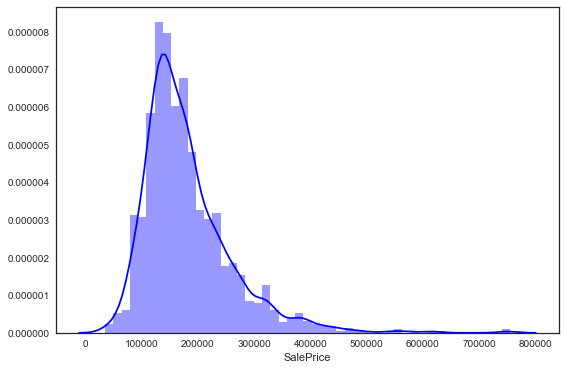

In [390]:
print("Skewness of the original target variable:", skew(train["SalePrice"]))

f, ax = plt.subplots(figsize=(9, 6))
sns.distplot(train['SalePrice'], color="b")

We see that the target variable is positively skewed.  
For linear and logistic regression we would like to make sure that the relationship between input variables and output variables is approximately linear, that the input variables are approximately normal in distribution, and that the output variable have constant variation (that is, the variance of the output variable is independent of the input variables).   
We might consider applying some (log) transformations in order to normalize the data.

We want to test the null-hypothesis on a 5% level that the our data are sampled from a normally distributed population.

Test for normality

In [391]:
x = train['SalePrice']

shapiro_results = shapiro(x)
print shapiro_results

# 3.206247534576162e-33 = 3.206247534576162 * 10^(-33) (very small)



(0.869671642780304, 3.206247534576162e-33)


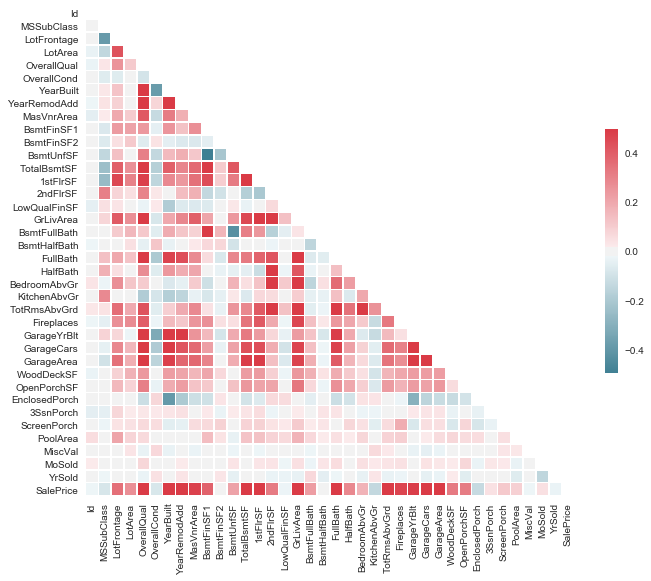

In [392]:
from string import ascii_letters

sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Maybe it's a good naive start on identifying strong correlation between Y and X and also a visual warning about correlation between many of the X's that needs to be dealt with.

I am also wondering whether a : backward selection is a good idea.

Backward selection. We start with all variables in the model, and backward remove the variable with the largest p-value—that is, the variable that is the least statistically significant. The new (p − 1)-variable model is fit, and the variable with the largest p-value is removed. This procedure continues until a stopping rule is reached. For instance, we may stop when all remaining variables have a p-value below some threshold.

In [393]:
# See the corrrelations
corr_list = corr['SalePrice'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

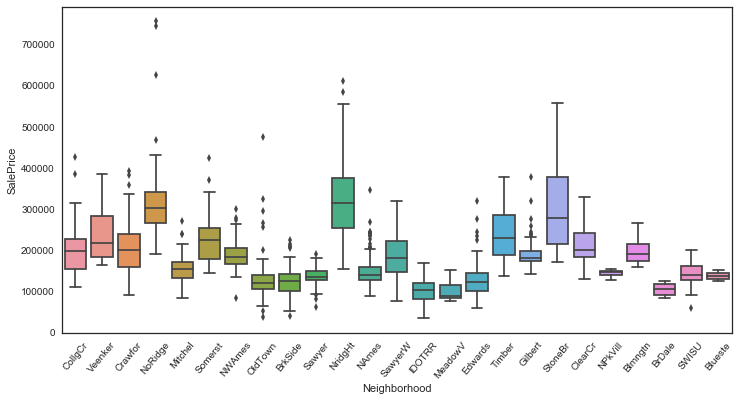

In [394]:
# Check neighborhood importance
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = train)
xt = plt.xticks(rotation=50)

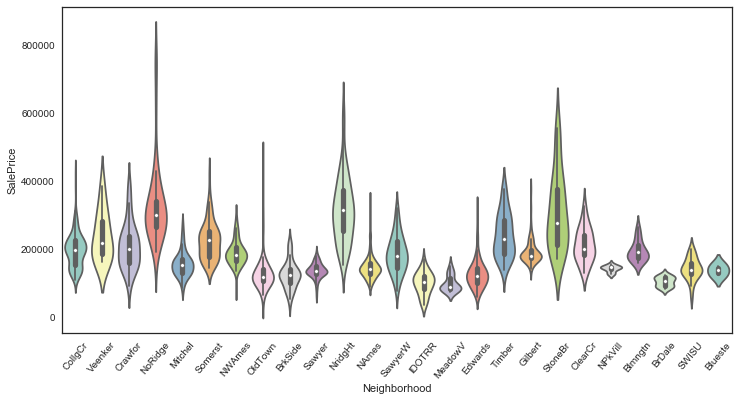

In [395]:
plt.figure(figsize = (12, 6))
ax = sns.violinplot(x = 'Neighborhood', y = 'SalePrice',  data = train,scale="width", palette="Set3")
xt = plt.xticks(rotation=50)

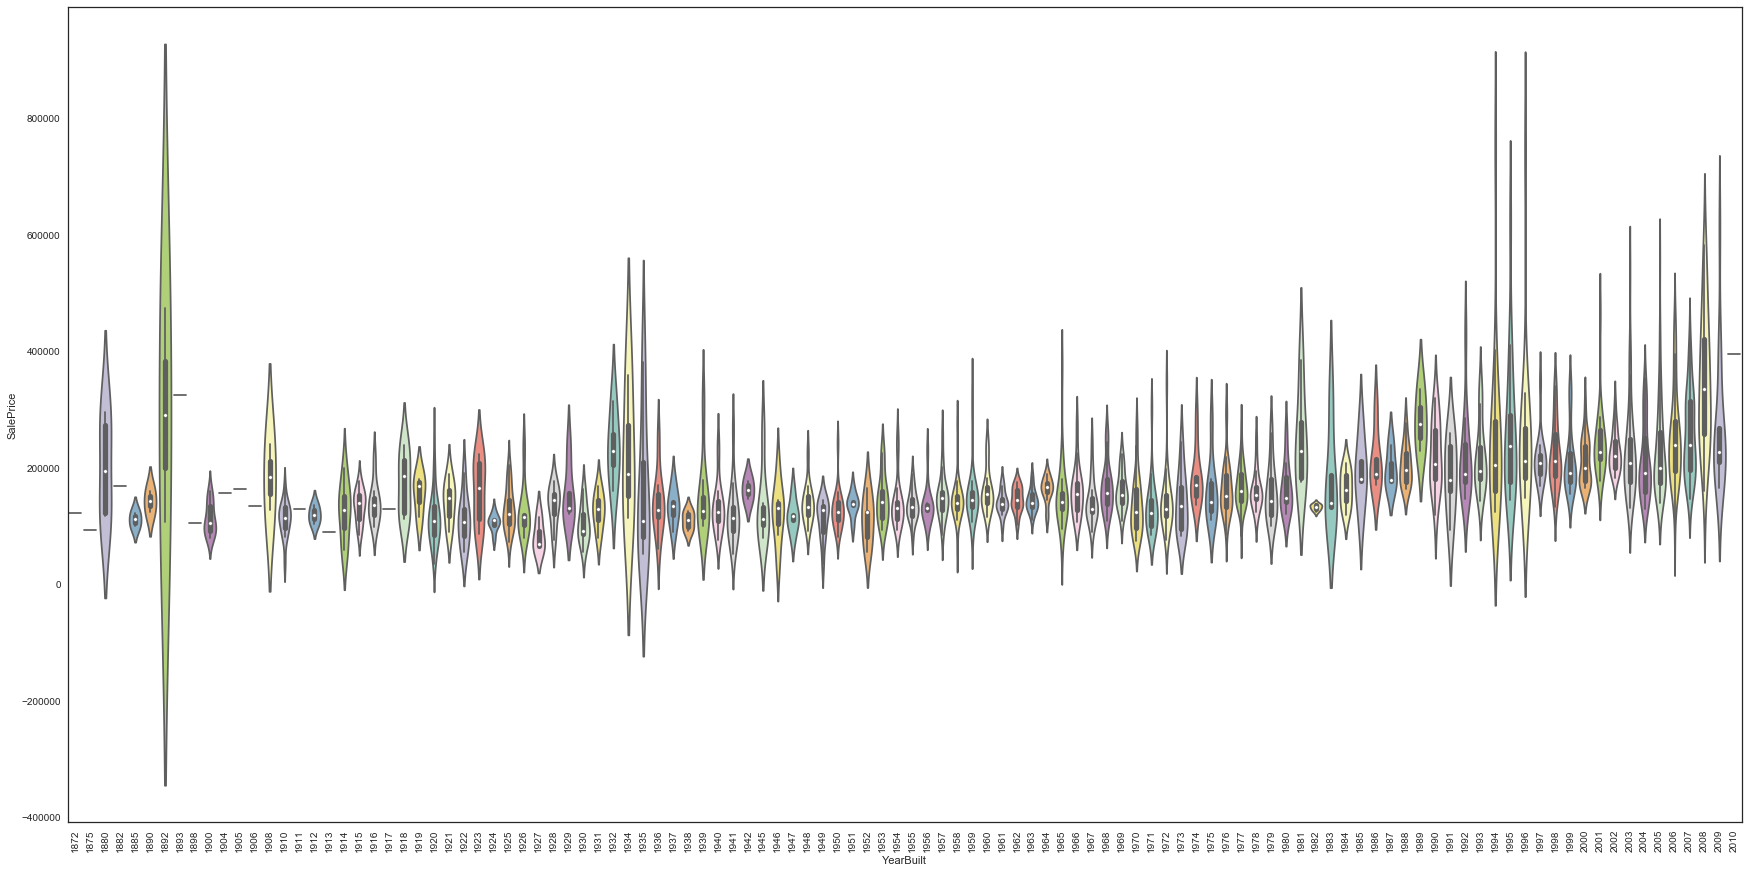

In [396]:
plt.figure(figsize = (30, 15))
ax = sns.violinplot(x = 'YearBuilt', y = 'SalePrice',  data = train,scale="width", palette="Set3")
xt = plt.xticks(rotation=90)




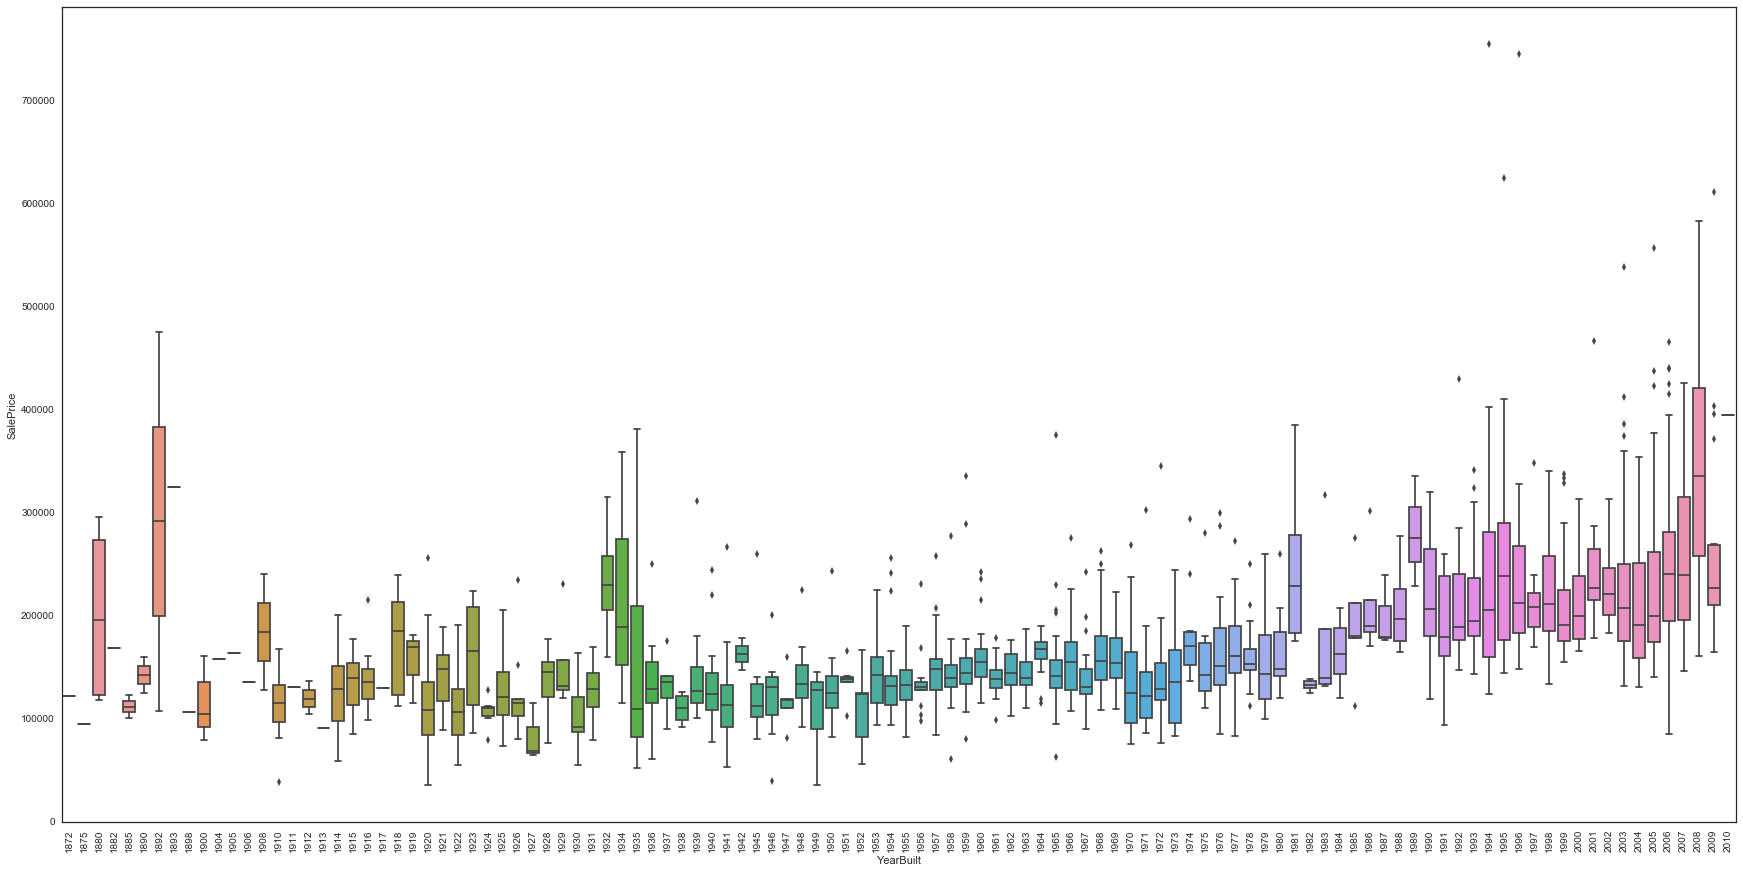

In [397]:
# trying the same with a box plot

plt.figure(figsize = (30, 15))
ax = sns.boxplot(x = 'YearBuilt', y = 'SalePrice',  data = train,)
xt = plt.xticks(rotation=90)

(0, 800000)

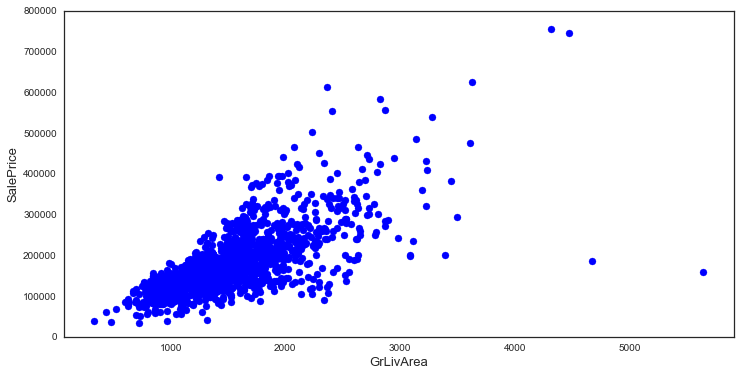

In [398]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice, color = 'blue')
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [399]:
# missing values 
selection = [field for field in train.columns.values if field not in ['SalePrice', 'Id']]
train_mod = train[selection]
train_mod['Train'] = 'Y'
print len(train_mod)

selection = [field for field in test.columns.values if field not in ['SalePrice', 'Id']]
test_mod = test[selection]
test_mod['Train'] = 'N'
print len(test_mod)

frames = [train_mod, test_mod]
pd.concat(frames)
aggregated_data = pd.concat(frames)
aggregated_data['Train'].value_counts()

1460
1459


Y    1460
N    1459
Name: Train, dtype: int64

In [400]:
def feature_summary(data):
    n_row = data.shape[0]
    features = pd.DataFrame()
    features_names = []
    features_counts = []
    features_missing = []
    names = data.columns.values
    for i in names:
        features_names.append(i)
        features_counts.append(data[i].value_counts().count())
        features_missing.append(data[data[i].isnull()].shape[0])
    features['name'] = features_names
    features['value counts'] = features_counts
    features['missing'] = features_missing
    features['percentage_missing'] = features['missing']/n_row
    return (features)

# feature_summary(train).to_csv('feature_summary.csv')
feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[:35]

,name,value counts,missing,percentage_missing
71,PoolQC,3,2909,0.996574
73,MiscFeature,4,2814,0.964029
5,Alley,2,2721,0.932169
72,Fence,4,2348,0.804385
56,FireplaceQu,5,1420,0.486468
2,LotFrontage,128,486,0.166495
63,GarageCond,5,159,0.054471
62,GarageQual,5,159,0.054471
58,GarageYrBlt,103,159,0.054471
59,GarageFinish,3,159,0.054471


In [401]:
def list_uniq_column_entries(col_list):
    for list_item in col_list:
        print(aggregated_data[aggregated_data[list_item] > 0][list_item].value_counts())
        
list_uniq_column_entries(list(feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[:5]['name']))

Gd    4
Ex    4
Fa    2
Name: PoolQC, dtype: int64
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
Grvl    120
Pave     78
Name: Alley, dtype: int64
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64


The first two variables have really high amounts of missing variables, which don't really add any predictive power.
* `PoolQC` 
* `MiscFeature`



The next 3 variables have a sufficiently large spread for us to consider imputing the missing data with a default or *NA* value.
* `Alley` 
* `Fence`
* `FireplaceQu`

In [402]:
aggregated_data.drop(['PoolQC','MiscFeature'], 1, inplace=True)

In [403]:
def impute_NaN(col_list, replace_var):
    for list_item in col_list:
        aggregated_data[list_item] = aggregated_data[list_item].map(lambda x: replace_var if type(x) != str else x)
#         print train[list_item].value_counts()

impute_NaN(['Alley', 'Fence', 'FireplaceQu'], 'NA')

Out of the next 10 variables, some are numerical and some are categorical (including year). 

Numerical variables that are substitueted/filled with mean:
* `LotFrontage`
* `MasVnrArea,`

Categorical variables that were substitueted/filled with *NA*s:
* `GarageYrBlt`
* `GarageCond`
* `GarageType`
* `GarageFinish`
* `GarageQual`
* `BsmtFinType2`
* `BsmtExposure`
* `BsmtQual`
* `BsmtCond`
* `BsmtFinType1`
* `MasVnrType`

In [404]:
list_uniq_column_entries(list(feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[5:10]['name']))

Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64
No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64
TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64
Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64


In [405]:
list_uniq_column_entries(list(feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[10:15]['name']))

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64
120.0     15
176.0     13
200.0     13
216.0     12
180.0     12
144.0     11
72.0      11
108.0     11
16.0      11
340.0     10
80.0       9
128.0      9
210.0      9
196.0      9
302.0      8
40.0       8
170.0      8
132.0      8
178.0      8
256.0      8
50.0       7
360.0      7
260.0      7
174.0      7
320.0      7
84.0       7
252.0      7
300.0      7
420.0      7
186.0      7
          ..
426.0      1
217.0      1
1050.0     1
584.0      1
187.0      1
668.0      1
97.0       1
652.0      1
692.0      1
452.0      1
436.0      1
381.0      1
262.0      1
481.0      1
435.0      1
594.0      1
894.0      1
451.0      1
391.0      1
970.0      1
710.0      1
738.0      1
734.0      1
518.0      1
975.0      1
549.0      1
515.0      1
1047.0     1
573.0      1
382.0      1
Name: MasVnrA

In [406]:
list_uniq_column_entries(list(feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[15:25]['name']))

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
1.0    171
2.0      4
Name: BsmtHalfBath, dtype: int64
AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64
TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64
384.0     19
728.0     14
672.0     13
600.0     12
100.0     11
216.0     11
572.0     11
816.0     11
624.0     10
270.0     10
300.0     10
396.0      9
280.0      9
186.0      9
264.0      9
768.0      9
348.0      8
294.0      8
840.0      8
480.0      8
108.0      8
162.0      8
546.0      8
780.0      8
440.0      8
832.0      8
448.0      7
120.0      7
630.0      7
784.0      7
          ..
1410.0     1
127.0      1
889.0      1
214.0      1
760.0      1
1411.0     1
584.0      1
1066.0     1
1107.0     1
79.0       1
388.0      1
1616.0     1
559.0      1
999.0      1
659.0      1
709.0      1
1214.0     1
657.0      1
587.0      1
1146.0     1
2140.0     1
579.0      

In [407]:
list_uniq_column_entries(list(feature_summary(aggregated_data).sort_values('percentage_missing', ascending = False)[25:35]['name']))

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64
2.0    1594
1.0     776
3.0     374
4.0      16
5.0       1
Name: GarageCars, dtype: int64
576.0     97
440.0     96
240.0     69
484.0     68
528.0     65
400.0     58
480.0     54
264.0     51
288.0     50
308.0     48
280.0     30
420.0     29
336.0     29
216.0     23
462.0     23
672.0     23
384.0     21
506.0     21
504.0     21
286.0     20
312.0     19
550.0     17
525.0     17
495.0     17
624.0     17
352.0     17
360.0     1

In [408]:
def impute_custom(col_list, replace_var, target_value):
    for list_item in col_list:
        aggregated_data[list_item] = aggregated_data[list_item].map(lambda x: replace_var if pd.isnull(x) else x)

impute_NaN(['GarageCond', 'GarageType', 'GarageFinish','GarageQual', \
            'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', \
            'BsmtFinType1', 'MasVnrType', 'Electrical', 'MasVnrArea',\
            'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st',\
            'Exterior2nd','SaleType'], 'NA')

impute_custom(['GarageYrBlt'], 2005, 0)
impute_custom(['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'], 0, 0)
impute_custom(['LotFrontage'], aggregated_data['LotFrontage'].median(), 0)
impute_custom(['BsmtFinSF1'], aggregated_data['BsmtFinSF1'].median(), 0)
impute_custom(['BsmtFinSF2'], aggregated_data['BsmtFinSF2'].median(), 0)
impute_custom(['BsmtUnfSF'], aggregated_data['BsmtUnfSF'].median(), 0)
impute_custom(['TotalBsmtSF'], aggregated_data['TotalBsmtSF'].median(), 0)

('Skewness of the transformed target variable:', 0.12122191311528359)


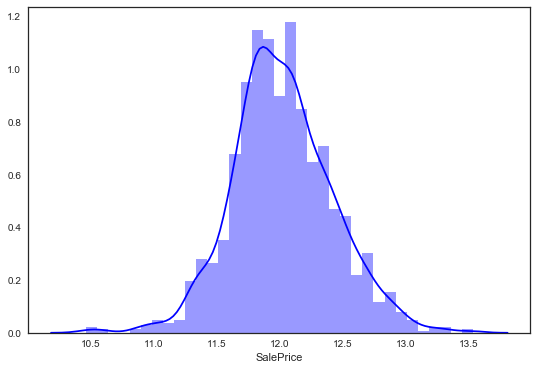

In [409]:
#Applying a log transform in the data
train['SalePrice'] =  np.log1p(train["SalePrice"])
print("Skewness of the transformed target variable:", skew(train["SalePrice"]))

f, ax = plt.subplots(figsize=(9, 6))
sns.distplot(train['SalePrice'], color="b")

In [410]:
aggregated_data = pd.get_dummies(aggregated_data)

In [411]:
train_temp = aggregated_data[aggregated_data['Train_Y'] == 1]
train_temp['SalePrice'] = train['SalePrice']
train = train_temp

test = aggregated_data[aggregated_data['Train_Y'] == 0]
print train.shape, test.shape

(1460, 305) (1459, 304)


In [412]:
from sklearn.cross_validation import train_test_split  #split the data 

target = train['SalePrice']

predictors_list = [field for field in train.columns.values if field != 'SalePrice'] # my predictors are everything but the sales price
predictors = train[predictors_list]

# Split test and training data - using a 30-70 split
X_train, X_test, Y_train, Y_test = train_test_split(predictors, target,\
                                                    test_size=0.3, random_state = 42)

alphas = 10**np.linspace(6,-2,100)*0.5

kf = KFold(n_splits = 5, random_state = 42) # doing a 5 fold cross validation
kf.get_n_splits(X_train)

# RMSE Calculator
def RMSE(y_predicted, y_actual):
    return (np.mean((y_predicted - y_actual)**2))

In [413]:
# RIDGE
ridge_lambda_rmse = []

for alpha in alphas:
    
    cv_ridge = []

    for train, test in kf.split(X_train):
        ridge = Ridge(random_state = 1000, alpha = alpha)
        ridge.fit(X_train.iloc[train], Y_train.iloc[train])

        yhat = ridge.predict(predictors.iloc[test])
        y_actual = target[test]
        cv_ridge.append(RMSE(yhat,y_actual))
    
    ridge_lambda_rmse.append((alpha, np.mean(cv_ridge)))

In [414]:
ridge_lambda_rmse

[(500000.0, 0.032684336675743317),
 (415108.78406598762, 0.032122959468041605),
 (344630.60521748476, 0.031604780252530676),
 (286118.38296751102, 0.031131687804097679),
 (237540.50810513966, 0.030704475763436517),
 (197210.3029718828, 0.030323033869875358),
 (163727.45814388659, 0.029986419786716491),
 (135929.41213664701, 0.029692825298438631),
 (112850.98598169608, 0.029439501599149459),
 (93690.871143019147, 0.029222721833510028),
 (77783.807196523616, 0.029037836102594854),
 (64577.483250744132, 0.028879431596545414),
 (53613.361100516158, 0.028741570000391337),
 (44510.754272251965, 0.028618051461970016),
 (36953.610167628874, 0.028502653516910937),
 (30679.536367065877, 0.028389308945385709),
 (25470.690074081875, 0.028272208828144751),
 (21146.214371947495, 0.028145837485156543),
 (17555.958671075638, 0.028004959897151061),
 (14575.26531412588, 0.027844588937892108),
 (12100.641323971917, 0.027659960911100966),
 (10046.165012825229, 0.027446545635552145),
 (8340.5026860002963, 

In [415]:
# LASSO
lasso_lambda_rmse = []

for alpha in alphas:

    cv_lasso = []
    
    for train, test in kf.split(X_train):
        lasso = Lasso(random_state = 42, alpha=alpha)
        lasso.fit(X_train.iloc[train], Y_train.iloc[train])

        yhat = lasso.predict(predictors.iloc[test])
        y_actual = target[test]
        cv_lasso.append(RMSE(yhat,y_actual))
    
    lasso_lambda_rmse.append((alpha, np.mean(cv_lasso)))

In [416]:
# Calculated RMSE for each fold and each alpha to determine best lambda
# Storing best values of lambda for Ridge and LASSO based on the lowest RMSE
best_lambda_ridge = sorted(ridge_lambda_rmse, key = lambda x: x[1])[0][0]
best_lambda_lasso = sorted(lasso_lambda_rmse, key = lambda x: x[1])[0][0]

# print best_lambda_lasso
# print best_lambda_ridge

print "Best Ridge lambda: {:.3f}".format(best_lambda_ridge)
print "Best LASSO lambda: {:.3f}".format(best_lambda_lasso)

Best Ridge lambda: 0.068
Best LASSO lambda: 0.005


In [417]:
# Calculated RMSE for each fold and each alpha to determine best lambda
# Storing best values of lambda for Ridge and LASSO based on the lowest RMSE 
### 
best_lambda_ridge_RMSE_pair = sorted(ridge_lambda_rmse, key = lambda x: x[1])[0]
best_lambda_lasso_RMSE_pair = sorted(lasso_lambda_rmse, key = lambda x: x[1])[0]

print best_lambda_lasso_RMSE_pair
print best_lambda_ridge_RMSE_pair


# Calculated RMSE for each fold and each alpha to determine best lambda
# Storing best values of lambda for Ridge and LASSO based on the lowest RMSE
best_lambda_ridge = sorted(ridge_lambda_rmse, key = lambda x: x[1])[0][0]
best_lambda_lasso = sorted(lasso_lambda_rmse, key = lambda x: x[1])[0][0]

print "Best Ridge lambda: {:.3f}".format(best_lambda_ridge)
print "Best LASSO lambda: {:.3f}".format(best_lambda_lasso)

(0.0050000000000000001, 0.020071676207361323)
(0.067652388728990237, 0.012717681991739957)
Best Ridge lambda: 0.068
Best LASSO lambda: 0.005


In [418]:
coef_ridge = []
coef_lasso = []

for alpha in alphas:

    # Storing coefficients for ridge 
    ridge = Ridge(random_state=42, alpha=alpha)
    ridge.fit(X_train, Y_train)
    coef_ridge.append(ridge.coef_)

    # Storing coefficients for lasso
    lasso = Lasso(random_state=42, alpha=alpha)
    lasso.fit(X_train, Y_train)
    coef_lasso.append(lasso.coef_)

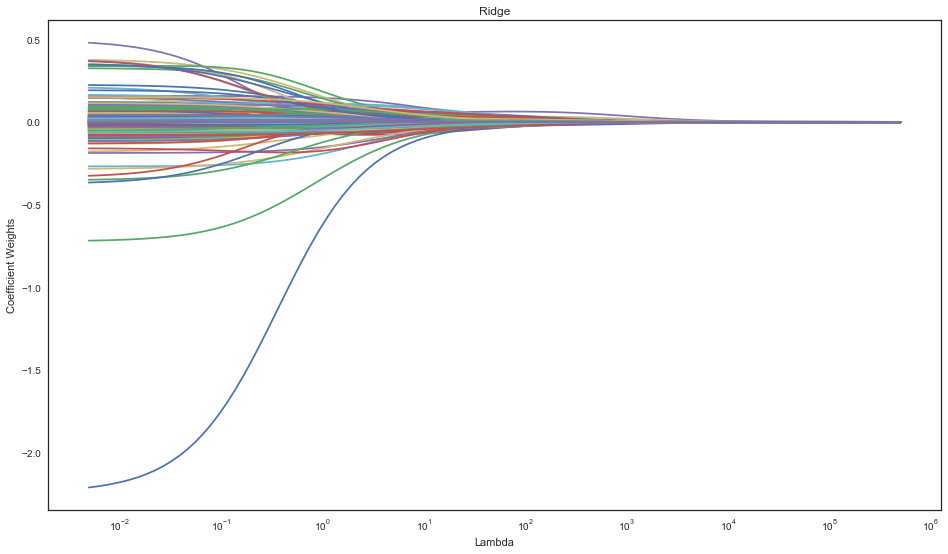

In [419]:
    
# Ridge
plt.figure(figsize=(16,9))
plt.plot(alphas, coef_ridge)
# plt.legend(coef_ridge)
plt.xscale('log')
plt.title("Ridge")
plt.xlabel("Lambda")
plt.ylabel("Coefficient Weights")
plt.show()



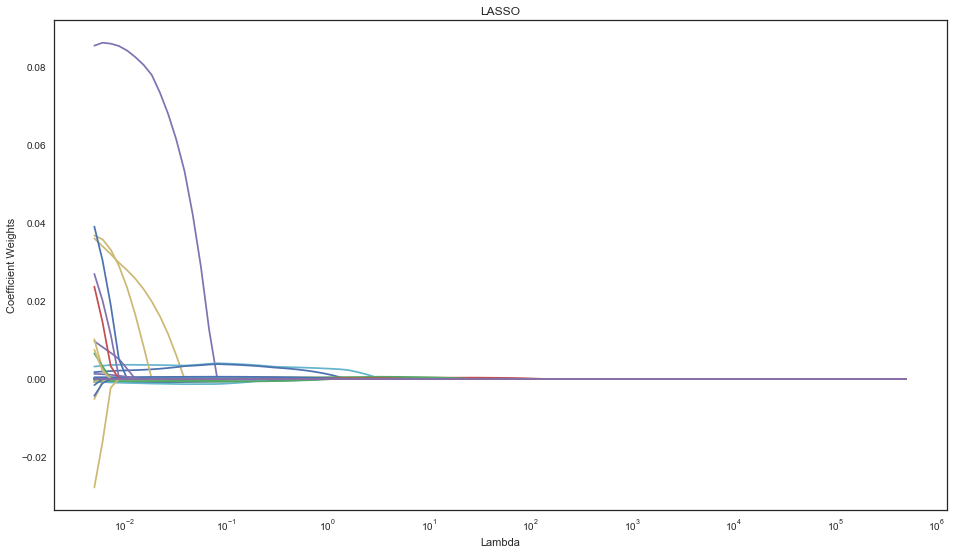

In [420]:
# Lasso
plt.figure(figsize=(16,9))
plt.plot(alphas, coef_lasso)
# plt.legend(coef_lasso)
plt.xscale('log')
plt.title("LASSO")
plt.xlabel("Lambda")
plt.ylabel("Coefficient Weights")
plt.show()

In [421]:
y_mean_baseline = np.mean(train)

In [422]:
# RMSE Calculator
def RMSE(y_predicted, y_actual):
    return (np.mean((y_predicted - y_actual)**2))

In [423]:
#train

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [424]:
target

print np.mean(target)

12.0240573949


In [425]:
y_hat_baseline = np.repeat(np.mean(target), len(target))
print y_hat_baseline

[ 12.02405739  12.02405739  12.02405739 ...,  12.02405739  12.02405739
  12.02405739]


In [426]:
RMSE(y_hat_baseline, target)

0.15945043447708565

In [427]:
y_hat_baseline = np.repeat(2.713**np.mean(target), len(target))
print y_hat_baseline

[ 162864.03786993  162864.03786993  162864.03786993 ...,  162864.03786993
  162864.03786993  162864.03786993]


In [428]:
target_actual = 2.713**target

RMSE(y_hat_baseline, target_actual)

6178540421.503625

In [429]:
#ridge.predict(X_train.iloc[test])

array([ 12.43702143,  11.67755597,  12.29104961,  12.26687233,
        12.11690906,  12.39749949,  11.82796888,  12.26096105,
        11.64233783,  11.76315   ,  11.82956753,  12.53570489,
        12.47742101,  11.69293521,  12.4376601 ,  12.47055034,
        12.01864129,  12.06982418,  12.37863813,  12.26718868,
        12.80774929,  11.7925858 ,  11.96177512,  11.68099972,
        11.90745178,  12.49432304,  11.44858755,  11.69415594,
        12.62395625,  11.8144117 ,  12.18545093,  11.48177601,
        11.89053234,  12.46699307,  11.99103227,  11.62511161,
        11.95446973,  11.66585199,  12.01954715,  11.98948639,
        11.85224014,  12.442968  ,  12.06500822,  12.32015155,
        12.02764744,  11.80178006,  11.95505755,  11.80087921,
        11.8311312 ,  11.95753152,  12.67103474,  11.65293008,
        11.84844821,  12.59603957,  12.2100582 ,  12.72928447,
        11.93377812,  12.4098263 ,  12.03715352,  11.77466996,
        12.15062912,  11.93584228,  11.95084341,  11.95

In [430]:
linear = LinearRegression()
ridge_bestAlpha = Ridge(random_state=42, alpha=best_lambda_ridge)
lasso_bestAlpha = Lasso(random_state=42, alpha=best_lambda_lasso)

# Fitting linear model
linear.fit(X_train, Y_train)
yhat_linear = linear.predict(X_test)

# Fitting Ridge model
ridge_bestAlpha.fit(X_train, Y_train)
yhat_ridge = ridge_bestAlpha.predict(X_test)

# Fitting LASSO model
lasso_bestAlpha.fit(X_train, Y_train)
yhat_lasso = lasso_bestAlpha.predict(X_test)

print "OLS Test MSE: {:.3f}".format(RMSE(yhat_linear, Y_test))
print "Ridge Test MSE: {:.3f}".format(RMSE(yhat_ridge, Y_test))
print "LASSO Test MSE: {:.3f}".format(RMSE(yhat_lasso, Y_test))

OLS Test MSE: 0.017
Ridge Test MSE: 0.017
LASSO Test MSE: 0.021


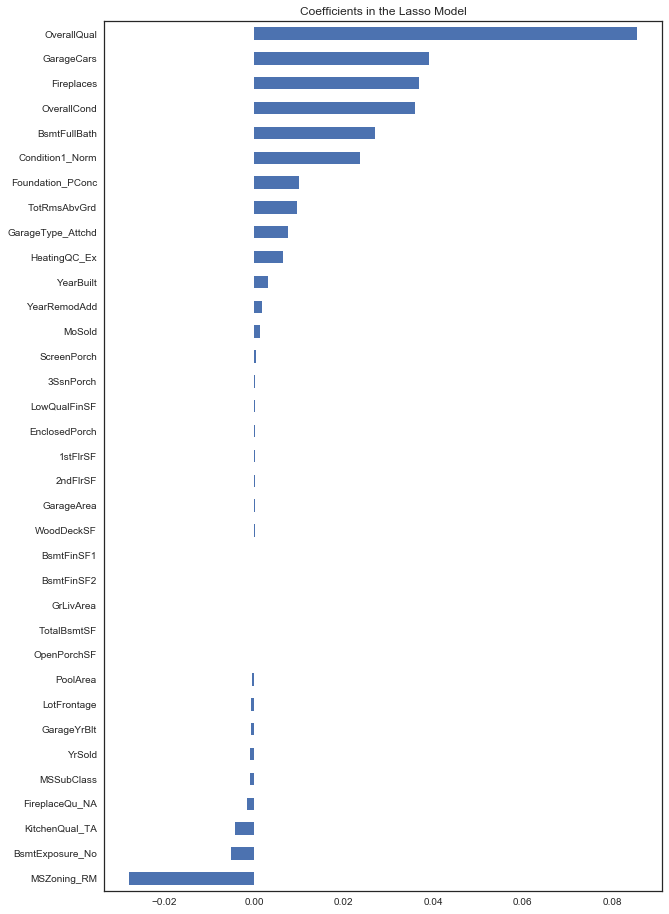

In [431]:
coef = pd.Series(lasso_bestAlpha.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(25)])
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [446]:
from sklearn.tree import DecisionTreeRegressor
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, Y_train)
pred = regr2.predict(X_test)

graph, = print_tree(regr2, features=X.columns)
Image(graph.create_png())

NameError: name 'print_tree' is not defined

In [437]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor

n_try = [3,6,9,12,15,20,25]
#n_try = [15,20,25,45,65,85,100]

rf_is_rmse = []
rf_rmse = []

for n in n_try:
    model_rf = RandomForestRegressor(n_estimators = n, random_state = 42)
    model_rf.fit(X_train, Y_train)
    y_pred_train = model_rf.predict(X_train)
    y_pred_test = model_rf.predict(X_test)
    rf_is_rmse.append(RMSE(y_pred_train, Y_train))
    rf_rmse.append(RMSE(y_pred_test, Y_test))
    
zip(rf_is_rmse, rf_rmse)

[(0.008579973245804551, 0.02571581721931888),
 (0.0059946980072998705, 0.023506717374018292),
 (0.004623190337565904, 0.021413561311630264),
 (0.0042117088263545505, 0.021791782726427643),
 (0.0037830763241896493, 0.02092106397430064),
 (0.0034020679899486694, 0.020560177433937125),
 (0.003288878499621012, 0.020516353204241097)]

In [455]:
# NOT WORKING 
# trying a grid search for the hyperparameters
from sklearn.model_selection import GridSearchCV
from time import time

# use a full grid over all parameters
param_grid = {"n_estimators" : [50,100,500],
              "max_depth" : [5,3,None],
              "max_features": [3,5,8],
              "min_samples_leaf": [1,3,10,20],
              
    
}

RF = RandomForestRegressor(n_jobs = 2)

# run a grid search
grid_search = GridSearchCV(RF, param_grid = param_grid)
start = time()
grid_search.fit(X_train, Y_train)

print('GridSearchCV took %.2f seconts for %d candidate parameter settings.'
     % (time() - start, len(grid_search.cv_results_['params'])))

#report grid_search.cv_results
grid_search.best_estimator_

GridSearchCV took 554.42 seconts for 108 candidate parameter settings.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [433]:
# Gradient Boosting Tree

from sklearn.ensemble import GradientBoostingRegressor

n_tree = [50, 100, 150, 200, 250, 300, 400, 500]
gb_is_rmse = []
gb_rmse = []

for n in n_tree:
    model_gb = GradientBoostingRegressor(n_estimators = n, random_state = 42)
    model_gb.fit(X_train, Y_train)
    y_pred_train = model_gb.predict(X_train)
    y_pred_test = model_gb.predict(X_test)
    gb_is_rmse.append(RMSE(y_pred_train, Y_train))
    gb_rmse.append(RMSE(y_pred_test, Y_test))
    
zip(gb_is_rmse, gb_rmse)

[(0.0094978506267131, 0.017738053306189328),
 (0.0057463116027185734, 0.016317422915533508),
 (0.004266465978751156, 0.016229649090107327),
 (0.0033706013088144354, 0.016135803275878977),
 (0.0026643007974210212, 0.016248722996576936),
 (0.00220239661671052, 0.01623534963797928),
 (0.0015231877803684553, 0.016428839102420184),
 (0.0010507019270182285, 0.016392525885940125)]

In [434]:
# Fitting Random Forest model
model_rf.fit(X_train, Y_train)
yhat_RF = model_rf.predict(X_test)

# Fitting Gradient Boosting Tree model
model_gb.fit(X_train, Y_train)
yhat_GB = model_gb.predict(X_test)

In [435]:
print "Random Forest Test MSE: {:.3f}".format(RMSE(yhat_RF, Y_test))
print "GBM Tree Test MSE: {:.3f}".format(RMSE(yhat_GB, Y_test))

Random Forest Test MSE: 0.021
GBM Tree Test MSE: 0.016


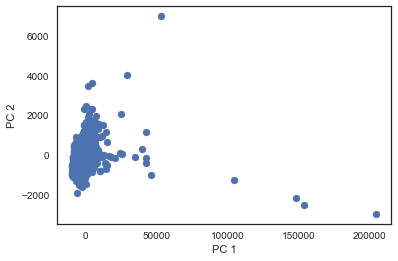

In [451]:
from sklearn.decomposition import PCA
%matplotlib inline 
from matplotlib import pyplot as plt

# gather the top two principal components from this dataset
# make a scatter plot with the first component as the x-axis and the second as the y-axis
pca = PCA(n_components=2)
transf = pca.fit_transform(X_train)
plt.scatter(transf[:,0],transf[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()